In [59]:
import os
import itertools 
import numpy as np
import cv2
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use("seaborn-whitegrid")
plt.rc("figure",autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold",titlesize=14, titlepad=10)

In [57]:
def plot_variance (pca, width=8, dpi=100):
    fig,axs=plt.subplots(1,2)
    n = pca.n_components_
    grid=np.arange(1,n+1)
    evr=pca.explained_variance_ratio_
    axs[0].bar(grid,evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0,1.0))
    
    cumv=np.cumsum(evr)
    axs[1].plot(np.r_[0,grid], np.r_[0,cumv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0,1.0))
       
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X,y,discrete_features):
    mi_scores = mutual_info_regression(X,y,discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores=mi_scores.sort_values(ascending=False)
    return mi_scores

def score_model(model, X_t=X_train, y_t=y_train, X_te=X_test, y_te=y_test):
    model.fit(X_t,y_t)
    preds=model.predict(X_te)
    return f1_score (y_te,preds,average='weighted')

def conf_matx(model, y_te=y_test, X_te=X_test):
    
    #Variable target avec les labels organisées:
    y_organised = ['10','2280','2403','2705','2522',
               '40','50','2905','2462','60',
               '1280','1281','1300','1180','1140','1160',
               '1320','1560',
               '2582','2583','2585','1302','2220',
               '1920','2060',
               '1301','1940']
    
    
    preds=model.predict(X_te)
    cnf_matrix = metrics.confusion_matrix(y_test,preds,labels=y_organised)
    y_organised

    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell/sum(line),2))
        pond_matrix.append(pond_line)
    cnf_matrix = np.array(pond_matrix)
    classes = y_organised

    plt.figure(figsize=(17,17))

    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Y TRUE')
    plt.xlabel(' PREDICTION')
    plt.show()

In [2]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0).squeeze().map(str)
path = os.getcwd() + '\\images\\image_train'
#Create a column with the name of the picture
X['image_name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image_path'] = path + r'\image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'

In [11]:
image_size = (50,50)
path_list = list(X['image_path'][:30000])
index_list = list(X[:30000].index)
label_list = list(y[:30000])
images_tuples = []
for path, idx, label in zip(path_list,index_list,label_list):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray_red = cv2.resize(img_gray, dsize = (image_size),interpolation = cv2.INTER_LANCZOS4 )
    images_tuples.append((idx,label,img_gray_red))

In [ ]:
    # cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_LANCZOS4, cv2.INTER_CUBIC (cv2 resize interpolation methods)
    # HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

In [14]:
column_names = ['index','label']
for pixel in range(image_size[0]*image_size[1]):
    column_names.append('pixel'+str(pixel+1))

images_list = []
for image in images_tuples:
    idx,label,img = image
    pixel_list = [idx,label]###
    for row_pixels in img:
        for pixel in row_pixels:
            pixel_list.append(pixel)
    images_list.append(pixel_list)
    ###
rakuten_images = pd.DataFrame(images_list,columns=column_names)
rakuten_images

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,0,10,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,2462,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29996,29996,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29997,29997,1140,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
29998,29998,1920,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [15]:
rakuten_images.to_csv('rakuten_reduced_all_images190821.csv',index_label='idx')

In [16]:
rakuten_reduced_images = pd.read_csv('rakuten_reduced_all_images190821.csv',index_col='index')
rakuten_reduced_images.drop(columns=['idx'],inplace=True)

In [17]:
target = rakuten_images['label']
data = rakuten_images.drop('label',1)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
data_scaled = data /255
X_pca=pca.fit_transform(data_scaled)

components_names = [f"PC{i+1}" for i in range (X_pca.shape[1])]
X_pca=pd.DataFrame(X_pca, columns=components_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-58.797495,-10.676896,0.315346,2.379071,0.067449,-0.156210,0.793821,0.623707,-0.041778,-0.482150,...,0.340404,0.088145,-0.315229,0.617019,0.271278,-0.084198,-0.017487,-0.256674,0.059597,0.369834
1,-58.796961,-8.349616,-0.368354,-1.331753,0.401352,-2.254907,3.468475,2.809666,-0.791257,-1.149421,...,-0.015661,0.028332,0.036887,-1.017129,-0.571266,0.024010,-0.897093,-1.464868,0.029449,0.141694
2,-58.788368,-11.173951,0.483949,3.918448,0.260242,0.025868,-1.081637,-0.166775,0.011104,0.322230,...,0.261839,-0.057027,-0.155453,0.031162,0.246584,0.518136,-0.001063,-0.373817,-0.111809,0.009095
3,-58.826502,9.484134,-2.958052,-9.186815,2.523523,0.127393,-5.038301,-1.167177,1.221931,-2.503684,...,-2.264122,-0.155125,-0.177386,1.523164,0.241920,0.315949,1.308121,-2.146109,1.286666,-0.807281
4,-58.785839,-7.744084,-0.628019,-1.259573,1.456006,-2.646412,2.313198,2.792829,-0.776164,0.828481,...,-1.573424,-0.154816,-0.861614,0.512366,0.240620,-0.143909,-0.860698,-0.522183,-0.352934,1.032593


load = pd.DataFrame(pca.components_,columns=components_names, index=X.columns)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

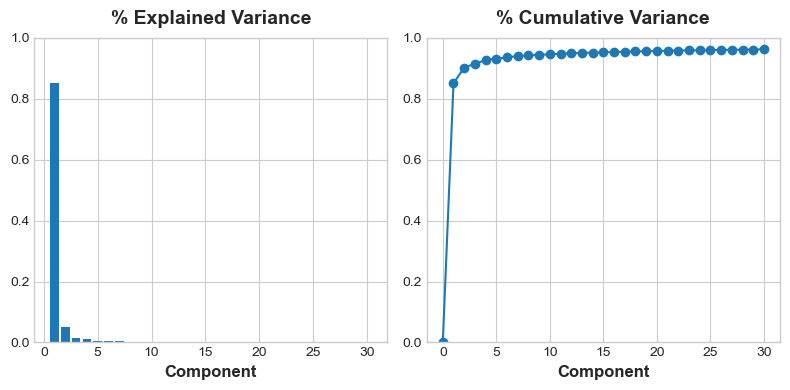

In [30]:
plot_variance(pca)

In [33]:
mi_scores=make_mi_scores(X_pca, target, discrete_features=False)
mi_scores

PC3     0.280267
PC2     0.132390
PC14    0.105423
PC7     0.095010
PC5     0.094688
PC12    0.089272
PC21    0.085718
PC4     0.072753
PC20    0.070526
PC8     0.069189
PC6     0.066642
PC26    0.065534
PC27    0.060387
PC10    0.057692
PC11    0.055940
PC15    0.052367
PC9     0.050270
PC28    0.044362
PC18    0.042658
PC22    0.038896
PC13    0.037643
PC30    0.030954
PC19    0.030835
PC16    0.030090
PC17    0.028072
PC25    0.026430
PC23    0.024580
PC29    0.012484
PC24    0.010777
PC1     0.002552
Name: MI Scores, dtype: float64

In [35]:
pca.fit(data)
print("composantes retenues :", pca.n_components_)

composantes retenues : 30


In [38]:
pca = PCA(n_components = 30)
X_train = data[:20000]
X_test = data[20000:]
X_train_scaled = X_train /255
X_test_scaled = X_test /255
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [40]:
y_train = y[X_train.index]
y_test = y[X_test.index]
print(y_train.shape, y_test.shape)

(20000,) (10000,)


In [44]:
# mod 1 
from sklearn.ensemble import RandomForestClassifier
m1_rf = RandomForestClassifier(n_jobs = -1, random_state=1)
score_model(m1_rf, X_train_pca, y_train, X_test_pca, y_test)

0.3161498320423335

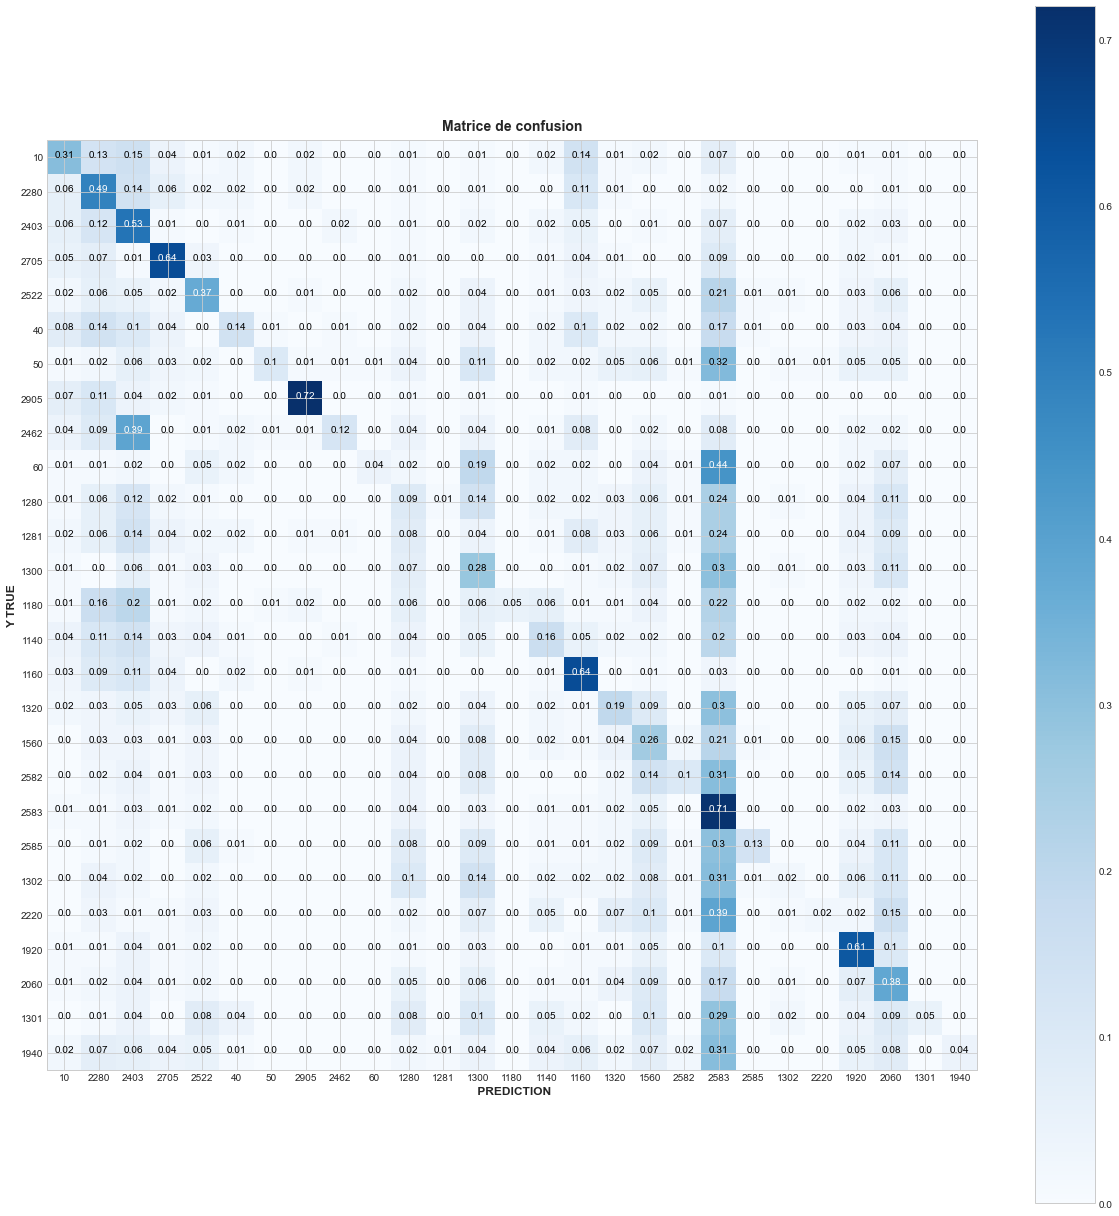

In [61]:
conf_matx(m1_rf,y_test,X_test_pca)

In [60]:
# mod 2 
from sklearn.ensemble import RandomForestClassifier
m2_xgb = XGBClassifier(n_jobs = -1)
score_model(m2_xgb, X_train_pca, y_train, X_test_pca, y_test)

C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:02:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.2912452788540094

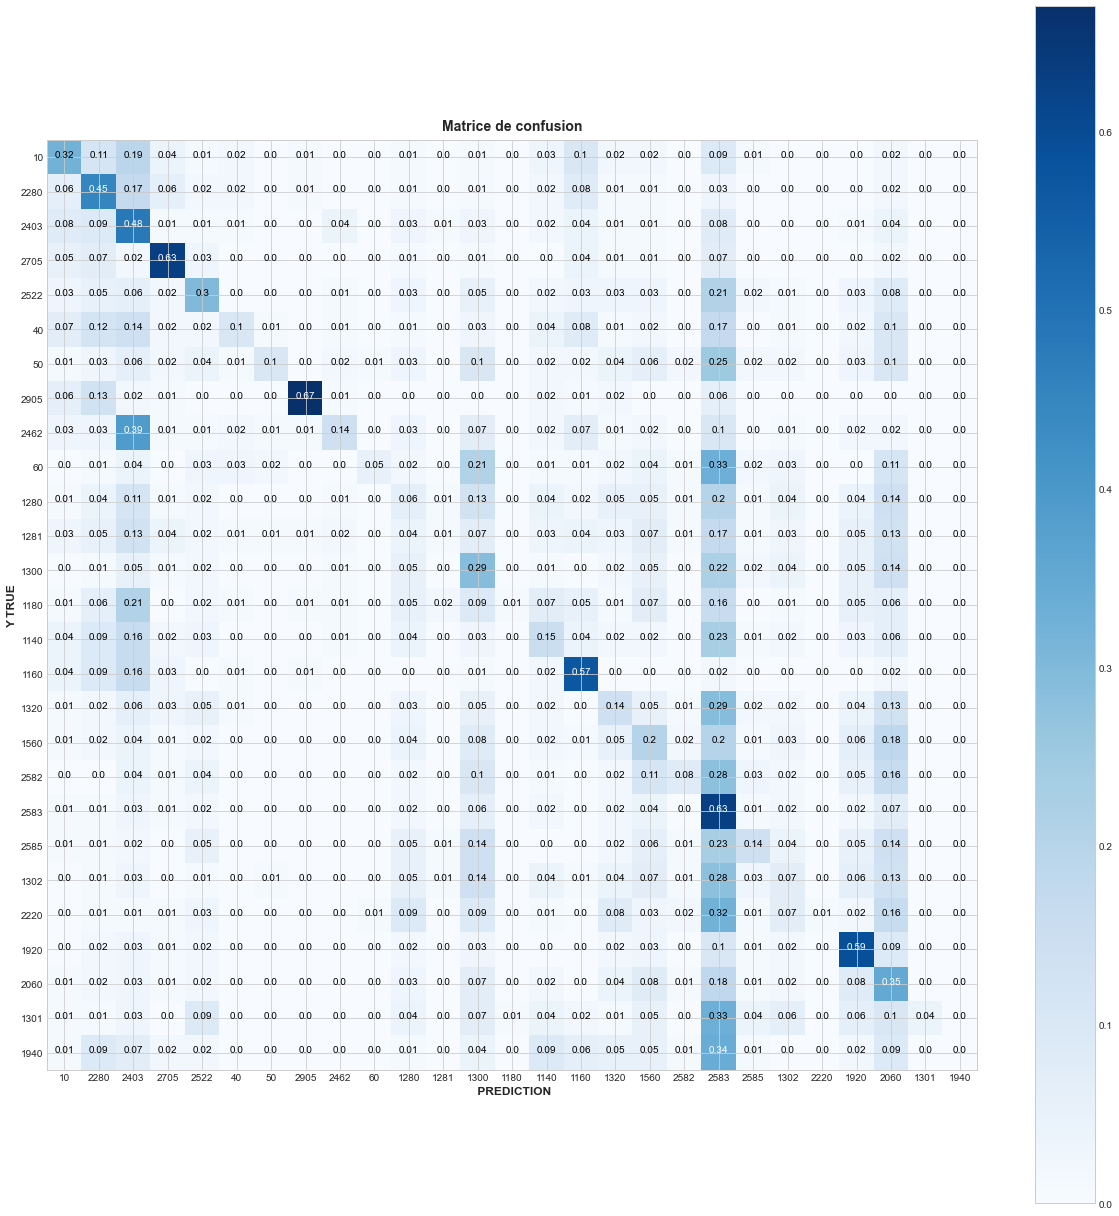

In [62]:
conf_matx(m2_xgb,y_test,X_test_pca)